## Motivation: to use a patiant's physical and clinical health indicators to determine whether the individual is suffering from a heart disease.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.activations import sigmoid, relu
from tensorflow.keras.losses import BinaryCrossentropy

from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

In [4]:
root_dir = './'
work_dir = os.getcwd() + '/'
data_loc = work_dir + 'Heart_disease_cleveland.csv'

In [7]:
df = pd.read_csv(data_loc)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


Check for the Null entries in the dataframe and if existed, handle them appropriately.

In [5]:
def manage_null(df,feature='',handle=''):
    
    feature_names = list(df.columns.values)
    feature_index = feature_names.index(feature)
    
    if handle == 'drop':
        # drop the column named 'feature'
        mod_df = df.drop(feature, inplace=False, axis=1)
    elif handle == 'mode':
        # replace null entries in column number == feature_index with the mode within the same column.
        mod_df = df.fillna(df.iloc[:,feature_index].mode()[0], inplace=False)
    elif handle == 'mean':
        # replace null entries in column number == feature_index with the mean value of the column.
        mod_df = df.fillna(df.iloc[:,feature_index].mean(), inplace=False)
    else:
        print(f"Handle {handle} not found.")
        return df
    
    return mod_df

It is known that under the <b>thal</b> feature, <b>0</b>'s are tantamount to Null. We first replace them with numpy's NaN and then handle them using <b>manage_null()</b>.

In [8]:
df.thal = df.thal.replace(0,np.NaN)
df = manage_null(df,'thal','mode')
df.tail()
df.shape

(303, 14)

A few definitions:

In [9]:
classes = np.unique(df.iloc[:,-1].values)
feature_names = list(df.columns.values)
feature_names.pop() # drop the last item, i.e. 'target', from the list

x = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
y = y.reshape(-1,1)

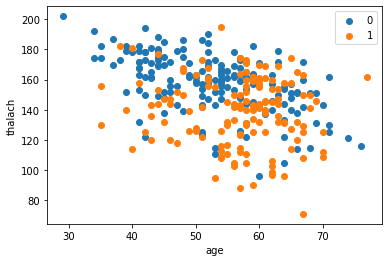

In [9]:
fig, ax = plt.subplots()
for cl in range(len(classes)):
    ax.scatter(df[feature_names[0]].loc[df["target"]==cl],
              df[feature_names[7]].loc[df["target"]==cl],
              label=classes[cl])
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[7])
ax.legend(loc='upper right')

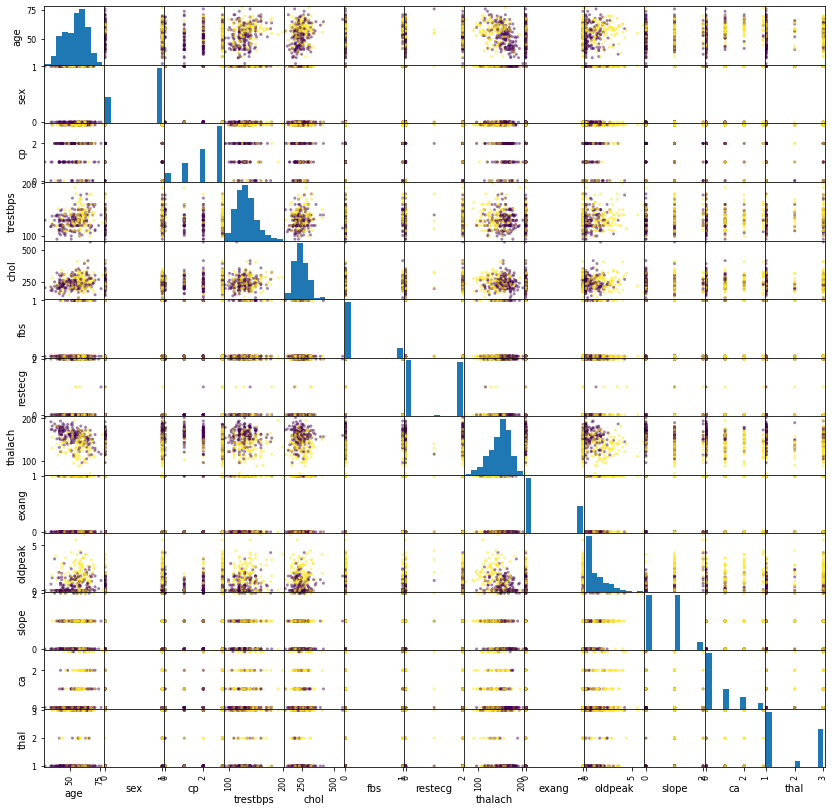

In [22]:
df_ = pd.DataFrame(x, columns=feature_names)
axs = pd.plotting.scatter_matrix(df_,c=y,figsize=(14, 14))

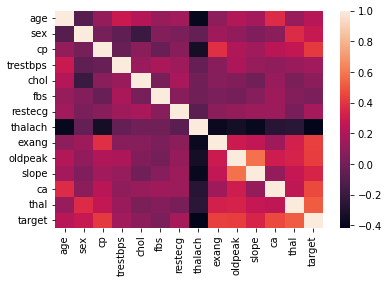

In [16]:
dataplot = sns.heatmap(df.corr())

### Artificial Neural Network, with Sequential dense layers.

In [22]:
# Model configuration
no_epochs = 200
no_classes = len(classes)
test_size = .2
validation_split = 0.2
verbosity = 0
rand_state = 1

# Load dataset
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = test_size, random_state = rand_state)

# Create the model
model = Sequential()
model.add(tf.keras.Input(shape=(13,)))
model.add(tf.keras.layers.Normalization(axis=-1))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit data to the model
history = model.fit(x_train, y_train,
                    validation_data=(x_test,y_test),
                    epochs=no_epochs,
                    verbose=verbosity
)

# Generate generalization metrics
print("Sequential model:\n")
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {score[0]} / Test accuracy: {score[1]}")

Sequential model:

Test loss: 0.3977367877960205 / Test accuracy: 0.8032786846160889


Let's visualize the loss and check for the convergence of the calculation.

/tmp/ipykernel_5251/1508769082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_5251/1508769082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

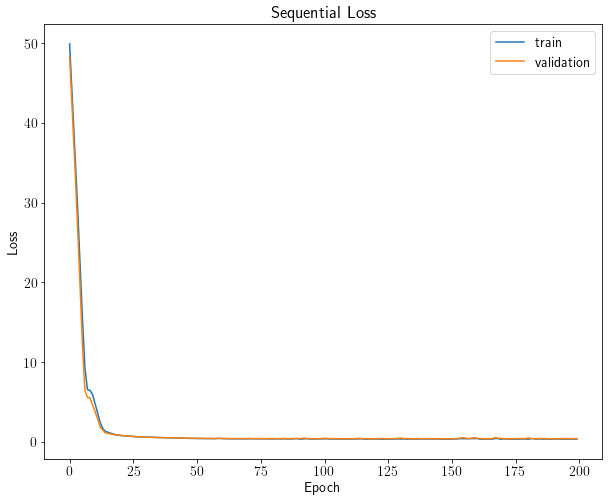

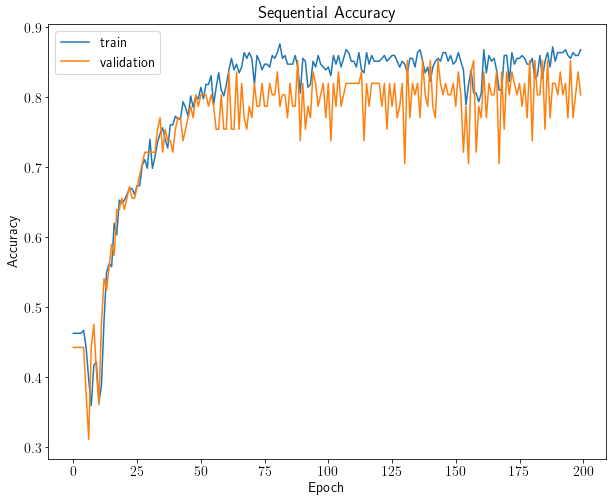

In [24]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Sequential Loss',figsize=(10,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Sequential Accuracy',figsize=(10,8)).set(xlabel='Epoch',ylabel='Accuracy')

### Logistic regression

In [18]:
lr_model = LogisticRegression()
lr_model.max_iter = 200
lr_model.fit(x_train,y_train)
y_pred = lr_model.predict(x_test)
y_pred = y_pred.reshape(-1,1)

print(f"{lr_model}:\n")
print(f"Generalization metric: {lr_model.score(x,y)}\n")
print(f"Classification report:\n{metrics.classification_report(y_test, y_pred)}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(y_test, y_pred)}")

LogisticRegression(max_iter=200):

Generalization metric: 0.8613861386138614

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        34
           1       0.84      0.78      0.81        27

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

Confusion matrix:
[[30  4]
 [ 6 21]]


/home/alireza/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alireza/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Let us evaluate the XGBoost method

Evaluating data to detect possibilities for categorical encoding.

In [30]:
nums = []# unique possibilities for each feature
for feature in df.columns:
    num = len(df.loc[:,feature].unique())
    nums.append(num)
    print(f"feature {feature:20s}: unique values = {num}")

feature age                 : unique values = 41
feature sex                 : unique values = 2
feature cp                  : unique values = 4
feature trestbps            : unique values = 50
feature chol                : unique values = 152
feature fbs                 : unique values = 2
feature restecg             : unique values = 3
feature thalach             : unique values = 91
feature exang               : unique values = 2
feature oldpeak             : unique values = 40
feature slope               : unique values = 3
feature ca                  : unique values = 4
feature thal                : unique values = 3
feature target              : unique values = 2


In [31]:
cat_features = ['cp','restecg','slope','ca','thal']
print(f"The multiclass categorical features are:\n{cat_features}")
dataOHE = pd.get_dummies(data = df, prefix = cat_features, columns = cat_features)

print(f"modified data shape: {dataOHE.shape}")
print(f"number of features: {dataOHE.shape[1]-1}")
print(f"number of examples: {dataOHE.shape[0]}")

dataOHE.head(5)

The multiclass categorical features are:
['cp', 'restecg', 'slope', 'ca', 'thal']
modified data shape: (303, 26)
number of features: 25
number of examples: 303


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,1,...,0,0,1,1,0,0,0,0,1,0
1,67,1,160,286,0,108,1,1.5,1,0,...,0,1,0,0,0,0,1,1,0,0
2,67,1,120,229,0,129,1,2.6,1,0,...,0,1,0,0,0,1,0,0,0,1
3,37,1,130,250,0,187,0,3.5,0,0,...,0,0,1,1,0,0,0,1,0,0
4,41,0,130,204,0,172,0,1.4,0,0,...,1,0,0,1,0,0,0,1,0,0


Redefine the data variables due to this new data set.

In [39]:
features = [x for x in dataOHE.columns if x != 'target'] ## Separate "target" from features
print(f"total number of features after one-hot encoding: {len(features)}")

total number of features after one-hot encoding: 25


In [41]:
x_train, x_test, y_train, y_test = train_test_split(dataOHE[features],dataOHE['target'],train_size=0.8, random_state=1)
print(f"X_train.shape = {x_train.shape}, X_dev.shape = {x_test.shape}")
print(f"y_train.shape = {y_train.shape}, y_dev.shape = {y_test.shape}")

X_train.shape = (242, 25), X_dev.shape = (61, 25)
y_train.shape = (242,), y_dev.shape = (61,)


In [42]:
n_estimators = 100 # default val (number of decision trees in the ensemble)
early_stopping_rounds = 20 # patience on stopping criteria
learning_rate = 0.1 # learning rate of the Gradient Descent
max_depth = 6 # max depth of the trees
lambda_ = 0 # regularization parameter
model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                      verbosity = 0, random_state = 1, early_stopping_rounds = early_stopping_rounds,
                      max_depth = max_depth,alpha=lambda_)
model.fit(x_train,y_train, eval_set = [(x_test,y_test)],verbose=False)

print(f"train: Accuracy score: {metrics.accuracy_score(model.predict(x_train),y_train)*100:.2f}%")
print(f"dev  : Accuracy score: {metrics.accuracy_score(model.predict(x_test),y_test)*100:.2f}%")

train: Accuracy score: 99.59%
dev  : Accuracy score: 80.33%


Further parameter tuning for the XGBoost model:

- finding the optimum regularization parameter
- finding the optimum "max depth"

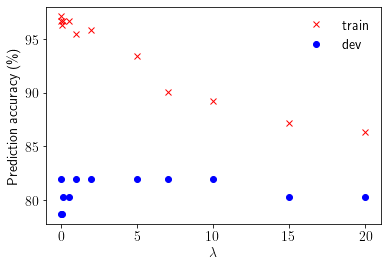

In [43]:
lambdas = [0, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 7, 10, 15, 20]
max_depth = 4
n_estimators = 100
train_acc = []
dev_acc = []
for lambda_ in lambdas:
    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                      verbosity = 0, random_state = 1, early_stopping_rounds = early_stopping_rounds,
                      max_depth = max_depth, alpha=lambda_)
    model.fit(x_train,y_train, eval_set = [(x_test,y_test)],verbose=False)
    train_acc.append(metrics.accuracy_score(model.predict(x_train),y_train)*100)
    dev_acc.append(metrics.accuracy_score(model.predict(x_test),y_test)*100)
    

plt.figure(figsize=(6,4))
plt.plot(lambdas,train_acc,'xr',label='train')
plt.plot(lambdas,dev_acc,'ob',label='dev')
plt.xlabel('$\lambda$')
plt.ylabel('Prediction accuracy (\%)')
plt.legend(frameon=False)
plt.show()

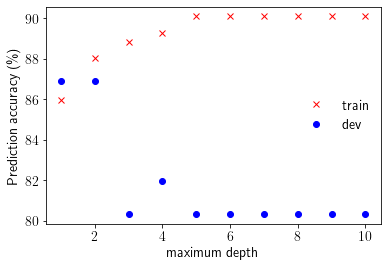

In [44]:
lambda_ = 10
max_depths = range(1,11)
n_estimators = 100
train_acc = []
dev_acc = []
for max_depth in max_depths:
    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                      verbosity = 0, random_state = 1, early_stopping_rounds = early_stopping_rounds,
                      max_depth = max_depth, alpha=lambda_)
    model.fit(x_train,y_train, eval_set = [(x_test,y_test)],verbose=False)
    train_acc.append(metrics.accuracy_score(model.predict(x_train),y_train)*100)
    dev_acc.append(metrics.accuracy_score(model.predict(x_test),y_test)*100)
    

plt.figure(figsize=(6,4))
plt.plot(max_depths,train_acc,'xr',label='train')
plt.plot(max_depths,dev_acc,'ob',label='dev')
plt.xlabel('maximum depth')
plt.ylabel('Prediction accuracy (\%)')
plt.legend(frameon=False)
plt.show()

Based on this parameter analysis, we optimize the XGBoost model by picking $\lambda = 10$ and $max depth=2$.

In [46]:
max_depth = 2
lambda_ = 10
n_estimators = 100
early_stopping_rounds = 20
learning_rate = 0.1

model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                      verbosity = 0, random_state = 1, early_stopping_rounds = early_stopping_rounds,
                      max_depth = max_depth,alpha=lambda_)
model.fit(x_train,y_train, eval_set = [(x_test,y_test)],verbose=False)

print(f"train: Accuracy score: {metrics.accuracy_score(model.predict(x_train),y_train)*100:.2f}%")
print(f"dev  : Accuracy score: {metrics.accuracy_score(model.predict(x_test),y_test)*100:.2f}%")

train: Accuracy score: 88.02%
dev  : Accuracy score: 86.89%
